神经网络基本原理

结构：输入层，输出层，隐藏层，激活函数，损失函数，优化器

过程：输入层接收原始数据-隐藏层对数据进行分析、判断(激活函数此时起作用，作用一：拟合复杂的边界，处理复杂的问题。作用二：保留或抑制信息传输的强度)-输出层输出分类后的结果-损失函数根据输出值和对应值进行比较，判断有多少数据偏离真实数据(数据‘有多错’)-优化器根据输出值和真实值的差距进行判断，反馈到隐藏层，对隐藏层的函数进行优化(调整每个函数中参数的权重，即反向传播+参数更新)

In [1]:
#导入必要的包
#基础库
import numpy as np   #数据计算,矩阵操作
import matplotlib.pyplot as plt   #绘图,结果可视化
#pytorch模块
import torch  #提供Tensor数据结构,Tensor是神经网络中处理数据的基本单位
import torch.nn as nn  #包含损失函数等
import torch.nn.functional as F  #提供神经网络常用的函数
import torch.optim as optim  #pytorch的优化器模块
#sklearn模块,用于数据处理
from sklearn.model_selection import train_test_split  #将数据划分成训练集和测试集
from sklearn.preprocessing import StandardScaler  #将特征进行标准化
from sklearn.metrics import accuracy_score, mean_squared_error #分析模型的准确率,评估回归模型的误差

In [2]:
#二分类任务:将数据划分为两个类别(好或坏、对或错),以乳腺癌数据为例.
from sklearn.datasets import load_breast_cancer
#加载并处理数据,只保留0和1,构建二分类数据集
data=load_breast_cancer()
X=data.data[:30]
y=data.target[:30]

In [3]:
# 3. 拆分训练集和测试集
X_train, X_test = X[:25], X[25:]
y_train, y_test = y[:25], y[25:]
# 4. 标准化,将所有特征变换为标准正态分布,避免模型关注数值较大的特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)#fit_transform()：计算均值/方差并应用
X_test = scaler.transform(X_test)#用训练集的标准直接应用到测试集
# 5. 转为Tensor,神经网络只能输入Tensor类型的数据
#reshape(-1,1)代表将数据转化成二维数据,因为神经网络的输出是二维数据
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [4]:
# 6. 定义神经网络模型（输出为概率）
class CancerClassifier(nn.Module):#nn.Moudle是一个类,是pytorch中所有神经网络的父类模板
    def __init__(self):
        super(CancerClassifier, self).__init__()#super().__init__()用于继承父类函数
        self.fc1 = nn.Linear(30, 16)#nn.Linear(输入特征数,隐藏神经元数)
        self.fc2 = nn.Linear(16, 8)#16个神经元归类为8个
        self.out = nn.Linear(8, 1)#8个神经元归纳为一个结果
    def forward(self, x):#定义数据流动方式
        x = F.relu(self.fc1(x))#进行归类行动
        x = F.relu(self.fc2(x))#进行归类行动
        return torch.sigmoid(self.out(x))
#torch.sigmoid()确保输出的数据的范围为(0~1),被解释为“预测为正类的概率”,损失函数要用nn.BCELoss()
#更推荐直接return self.out(x),此时损失函数就要用nn.BCEWithLogitsLoss(),在内部直接进行sigmod()计算
model = CancerClassifier()
# 7. 损失函数与优化器
criterion = nn.BCELoss()#二分类专用损失函数自动计算错了多少
#model.parameters()把模型中所有需要学习的参数传进去
#lr=0.01：学习率，决定每次参数更新的大小,即每一次变换的长度
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
# 8. 模型训练
for epoch in range(100):
    model.train()#训练模式
    optimizer.zero_grad()#梯度清零,清除上一次训练的残留
    outputs = model(X_train_tensor)#把训练数据送入模型,得到模型的预测结果
    loss = criterion(outputs, y_train_tensor)#用损失函数比较预测值和真实值标签,越小越接近正确答案
    loss.backward()#计算每个参数的梯度,即“错在哪”(反向传播)
    optimizer.step()#根据梯度更新模型权重(改正错误)
    #每训练20次打印一次损失值,观测模型训练情况
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 20, Loss: 0.0450
Epoch 40, Loss: 0.0013
Epoch 60, Loss: 0.0004
Epoch 80, Loss: 0.0003
Epoch 100, Loss: 0.0002


In [11]:
# 9. 模型预测
model.eval()#切换为预测/评估模式
with torch.no_grad():#禁用梯度计算（节省显存，加快速度）
    pred_probs = model(X_test_tensor)#把测试数据送入模型,得到预测值(0~1)
    pred_labels = (pred_probs >= 0.5).float()#概率转换标签(>=0.5则转换为1)
# 10. 结果输出
print("\n真实标签：", y_test.reshape(-1))#打印测试集的标签,转换为一维数组方便展示
print("预测结果：", pred_labels.numpy().reshape(-1))#打印模型预测结果,转换成numpy的一维数组,便于展示
acc = accuracy_score(y_test, pred_labels.numpy())#accuracy_score()计算模型在测试集上的准确率
print(f"✅ 测试集准确率：{acc:.4f}")


真实标签： [0 0 0 0 0]
预测结果： [0. 0. 0. 0. 0.]
✅ 测试集准确率：1.0000


<Figure size 600x600 with 0 Axes>

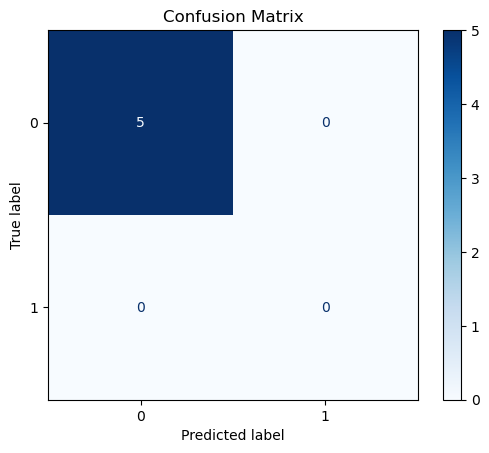

In [13]:
#绘图
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 生成混淆矩阵
cm = confusion_matrix(y_test, pred_labels.numpy(),labels=[0,1])#生成混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
# 绘图
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()